# Comparison of Image convolution and Smoothing Functions for Gammapy

This notebook is a mini benchmark for image convolution and smoothing functions, we'd like to use in Gammapy. We will compare:

 * [scipy.ndimage.convolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html)
 * [scipy.signal.fftconvolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html#scipy.signal.fftconvolve)
 * [scipy.signal.convolve2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)
 * [astropy.convolution.convolve](http://docs.astropy.org/en/stable/api/astropy.convolution.convolve.html#astropy.convolution.convolve)
 * [astropy.convolution.convolve_fft](http://docs.astropy.org/en/stable/api/astropy.convolution.convolve_fft.html#astropy.convolution.convolve_fft)
 * [scipy.ndimage.filters.gaussian_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.filters.gaussian_filter.html)
 * [scipy.ndimage.filters.uniform_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.filters.uniform_filter.html)
 
 
 
On a test image of the size 400 x 400 pixels it turns out that `scipy.signal.fftconvolve` is the fastest of the tested functions, except for very small kernel sizes (< 10 x 10 pixels) where `scipy.ndimage.convolve` is faster. For 
`scipy.signal.fftconvolve` the runtime only weakly depends on the kernel size. Choosing the fft convolution we might
avoid the need for energy dependent kernel sizes.

The benchmark was performed on an Dell Desktop with an i5-3570 CPU @ 3.40GHz × 4 and 8gb of RAM.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import timeit
from scipy.signal import convolve, convolve2d, fftconvolve
from scipy.ndimage import convolve as ndimage_convolve
from scipy.ndimage import gaussian_filter, uniform_filter
from astropy.convolution import convolve as convolve_astropy
from astropy.convolution import convolve_fft as fftconvolve_astropy
from astropy.convolution import Gaussian2DKernel, Box2DKernel

In [3]:
np.random.seed(0)

shape = (400, 400)
data = np.random.random(shape)
conv_functions = ['convolve2d', 'fftconvolve', 'ndimage_convolve', 'convolve_astropy', 'fftconvolve_astropy']
kernel_sizes = [5, 11, 21, 41, 81, 161]


## Convolution functions

In [4]:
results = {}
for conv_function in conv_functions:
    results[conv_function] = []
    
    for kernel_size in kernel_sizes:
        kernel = np.ones((kernel_size, kernel_size))
        timer = timeit.Timer(conv_function + '(data, kernel)', globals=globals())
        value = timer.timeit(2)
        results[conv_function].append(value)

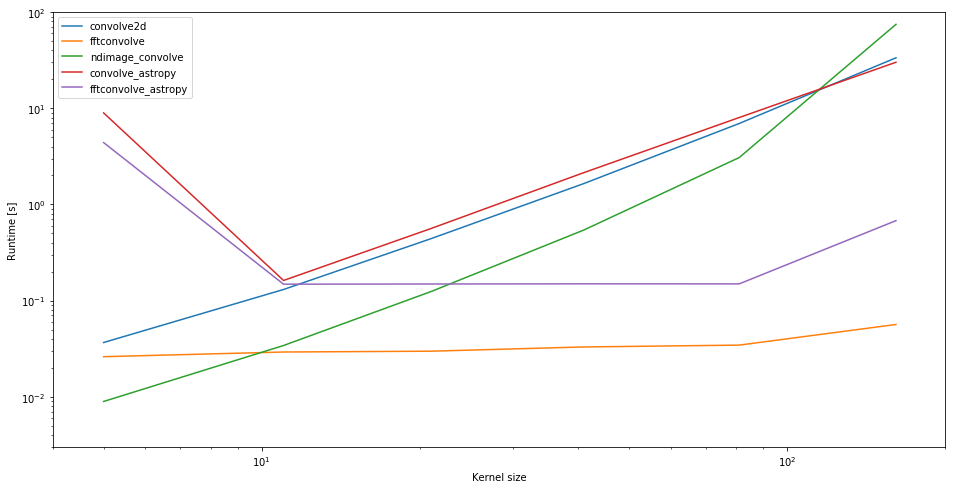

In [5]:
plt.figure(figsize=(16, 8))
for conv_function in conv_functions:
    plt.plot(kernel_sizes, results[conv_function], label=conv_function)
plt.legend(loc='upper left')
plt.loglog()
plt.xlabel('Kernel size')
plt.ylabel('Runtime [s]')
plt.xlim(4, 200)
plt.ylim(0.003, 100)
plt.savefig('convolution_toy_benchmark.png')

## Smoothing functions

In [8]:
def smooth_gaussian_fft(data, width):
    kernel = Gaussian2DKernel(width).array
    return fftconvolve(data, kernel)

def smooth_box_fft(data, width):
    kernel = Box2DKernel(width).array
    return fftconvolve(data, kernel)

In [13]:
smooth_functions = ['gaussian_filter', 'uniform_filter', 'smooth_gaussian_fft', 'smooth_box_fft']

results = {}

for smooth_function in smooth_functions:
    results[smooth_function] = []
    
    for width in kernel_sizes:
        timer = timeit.Timer(smooth_function + '(data, width)', globals=globals())
        value = timer.timeit(2)
        results[smooth_function].append(value)
    

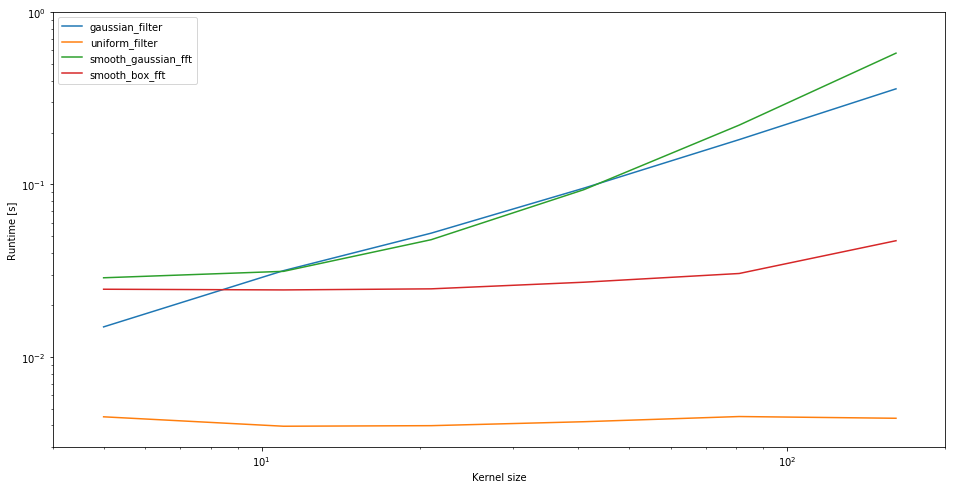

In [18]:
plt.figure(figsize=(16, 8))
for smooth_function in smooth_functions:
    plt.plot(kernel_sizes, results[smooth_function], label=smooth_function)
plt.legend(loc='upper left')
plt.loglog()
plt.xlabel('Kernel size')
plt.ylabel('Runtime [s]')
plt.xlim(4, 200)
plt.ylim(0.003, 1)
plt.savefig('smoothing_toy_benchmark.png')